In [1]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
import random

In [2]:
train_data = idx2numpy.convert_from_file('mnistdata/train-images.idx3-ubyte') / 255
train_label = idx2numpy.convert_from_file('mnistdata/train-labels.idx1-ubyte')
test_data = idx2numpy.convert_from_file('mnistdata/t10k-images.idx3-ubyte') / 255
test_label = idx2numpy.convert_from_file('mnistdata/t10k-labels.idx1-ubyte')

In [3]:
train_label.shape

(60000,)

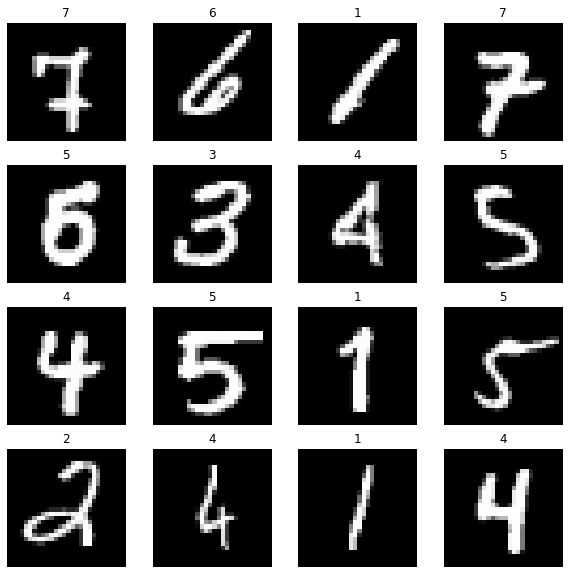

In [4]:
row , col = 4, 4
figure  = plt.figure(figsize=(10,  10))
for i in range(1, row*col+1):
    index = random.randint(1, len(train_data))
    img = train_data[index]
    label = train_label[index]
    figure.add_subplot(row, col, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img, cmap='gray')

In [5]:
def vactorize_label(*labels):
    out = []
    for label in labels:
        label = label.tolist()
        for i , val in enumerate(label):
            label_list = np.zeros(10, dtype=int)
            label_list[val] = 1
            label[i] = label_list
        label = np.array(label, dtype=object)
        out.append(label)
    return out

train_label, test_label=vactorize_label(train_label, test_label)

def data_loader_wrapper(train_data, train_label, test_data, test_label):
    train_data = [np.float32(x.reshape(784, 1)) for x in train_data]
    test_data = [np.float32(x.reshape(784, 1)) for x in test_data]
    train_label = [x.reshape(10,1) for x in train_label]
    test_label = [x.reshape(10,1) for x in test_label]
    training_data = [(data, label) for data, label in zip(train_data, train_label)]
    testing_data = [(data,label) for data, label in zip(test_data, test_label)]
    return training_data, testing_data

training_data, testing_data = data_loader_wrapper(train_data, train_label, test_data, test_label)

In [6]:
def sigmoid(z):
    return (1.0/(1.0+np.exp(-z.astype(float))))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z)) 

In [7]:
class Network:

    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
       
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for i, mini_batch in enumerate(mini_batches):
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print ("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for i, (x, y) in enumerate(mini_batch):
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):

        test_results = [((self.feedforward(x).argmax()), y.argmax())
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

In [8]:
net = Network([784, 16, 10])

net.SGD(training_data, 30, 10, 3.0, test_data=testing_data)